In [ ]:
# kutubxonalarni yuklab olish
import torch

import fastai

# versiyalarini tekshirish
print(torch.__version__)
print(fastai.__version__)

2.6.0+cu124
2.7.19


# Semantic Segmentation

### O'zi yurar avtomabillar uchun juda ham muhim bo'lgan rasmdagi turli xil obyektlarni ajrata olish (`semantic segmentation`) texnologiyasini modelini qurib ko'ramiz. Ya'ni modelimiz rasmdagi turli xil obyeklarni ajratib ularni turli xil ranglarda ko'rsatadi.

Buning uchun biz `Semantic object classes in video: A high-definition ground truth database` ilmiy maqolada qo'llanilgan datasetdan foydalanamiz.

In [ ]:
from fastai.vision.all import *
import numpy as np

# path
path = untar_data(URLs.CAMVID_TINY)
# !ls /root/.fastai/data/camvid_tiny

# label getter
def label_getter(file):
  return path/'labels'/f'{file.stem}_P{file.suffix}'

# dataloader
dls = SegmentationDataLoaders.from_label_func(path, bs=8, fnames=get_image_files(path/'images'),
                                              label_func=label_getter, codes=np.loadtxt(path/'codes.txt' ,dtype=str))

# fine-tune
learn = unet_learner(dls, resnet34)
learn.fine_tune(12)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 163MB/s]


epoch,train_loss,valid_loss,time
0,3.108520,2.624962,00:03


epoch,train_loss,valid_loss,time
0,1.924296,1.719040,00:01
1,1.634469,1.312339,00:01
2,1.436548,1.195830,00:01
3,1.302325,1.027398,00:01
4,1.165020,0.928031,00:01
5,1.047033,0.809282,00:01
6,0.945866,0.799290,00:01
7,0.865318,0.745141,00:01
8,0.793573,0.750455,00:01
9,0.731286,0.741988,00:01


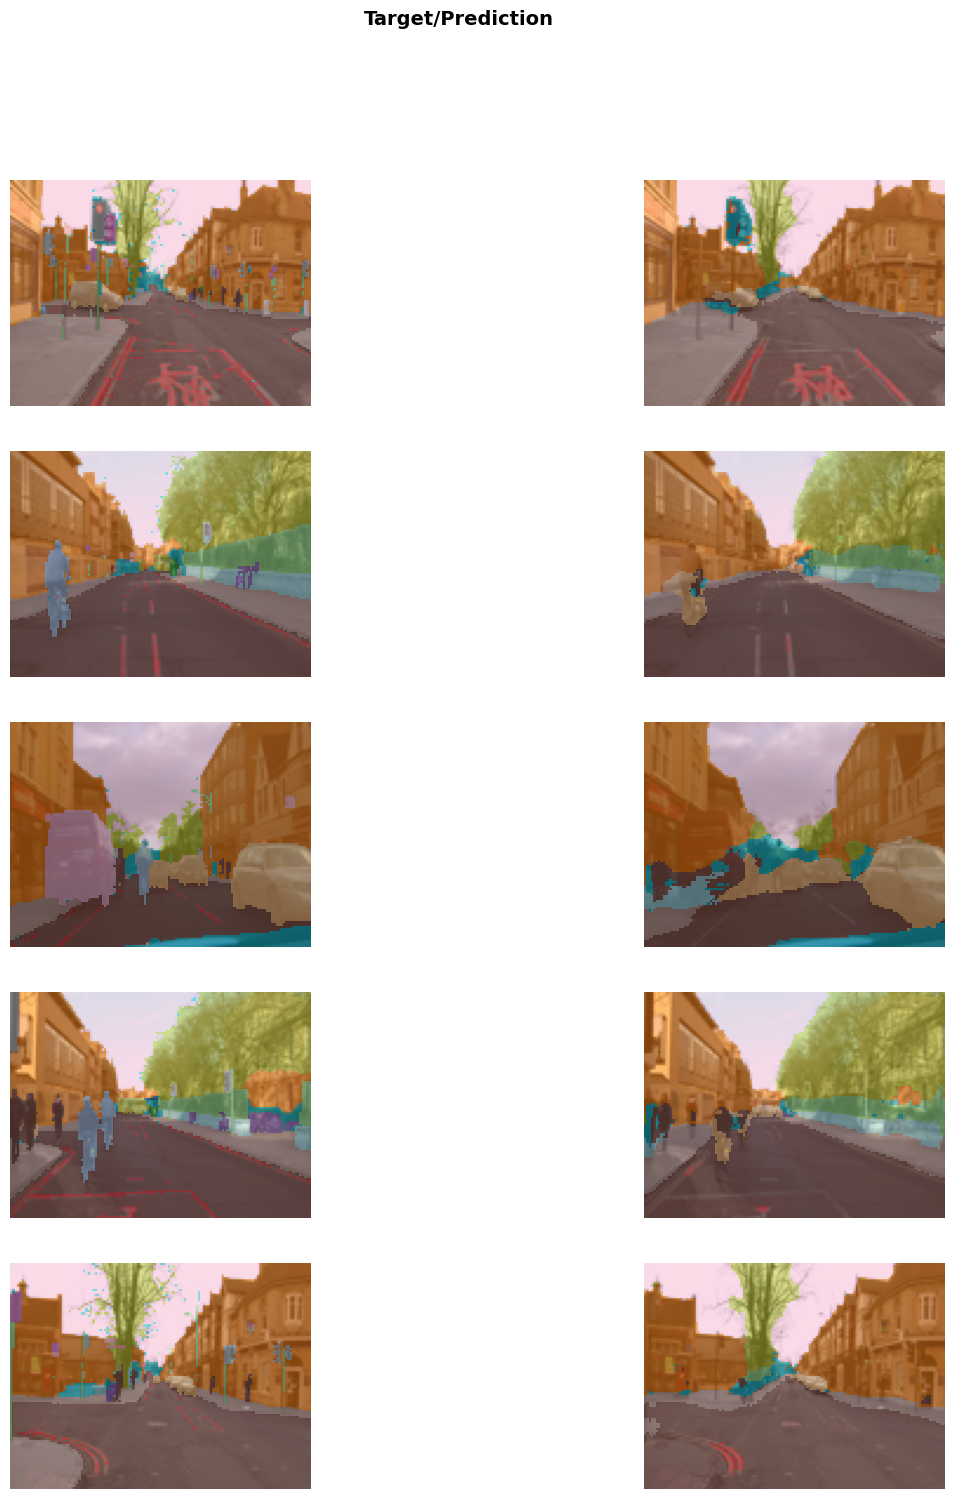

In [ ]:
learn.show_results(max_n=5, figsize=(15,17))

# Natural Language Processing (NLP)

### Navbatdagi misollimiz bu NLP(Natural Language Processing)ga yo'naltirilgan. Bu soha hozirda juda jadal rivojalanib borayotgan soha hisoblanadi. NLP o'z ichiga matnlar ishlab chiqa olish (generate), izohlarni tahlil qilish, gapdagi so'zlarni sinflash va h.k amallarni qamrab oladi.

### Hozir quradigan modelimiz ham [IMDb Review](https://ai.stanford.edu/~amaas/data/sentiment/) datasetda berilgan izohlardan kelib chiqgan holda, u izohning `ijobiy(positive)` yoki `salbiy(negative)` izoh ekanligini aniqlay oladi.

In [ ]:
from fastai.vision.all import *
from fastai.text.all import *

# dataset
path = untar_data(URLs.IMDB)

# Define TextBlock with explicit tokenization and numericalization
text_block = TextBlock(tok_tfm=Tokenizer(WordTokenizer()), seq_len=72, backwards=False, min_freq=3, max_vocab=60000)

# Create DataLoaders using the defined TextBlock
dataloader = DataBlock(
    blocks=(text_block, CategoryBlock),
    get_items=get_text_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    get_y=parent_label
).dataloaders(path, path=path, bs=64)h


# fine-tune
learn = text_classifier_learner(dataloader, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.467392,0.408068,0.817800,04:25


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


epoch,train_loss,valid_loss,accuracy,time


## Tabular data va Tabular model

### `Tabular data`: Tuzilishi jadval ko'rinishida bo'lgan ma'lumotlarni `tabular data` deb aytish mumkin.

### `Tabular model`: Bu jadvalning bir ustunini boshqa ustunidagi ma'lumotlarga tayanib o'qitilgan(trained) modelni tushinish mumkin.

In [ ]:
from fastai.vision.all import *
from fastai.tabular.all import *

# dataset
path = untar_data(URLs.ADULT_SAMPLE)

# dataloader
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, bs=64, y_names='salary', skipinitialspace=False,
                                  cat_names=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'],
                                  cont_names= ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'],
                                  procs = [Categorify, FillMissing, Normalize])

# o'qitish
learner = tabular_learner(dls, metrics=accuracy)
learner.fit_one_cycle(4)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


epoch,train_loss,valid_loss,accuracy,time
0,0.365358,0.339786,0.850123,00:05
1,0.326089,0.306775,0.859490,00:04
2,0.316419,0.312153,0.853808,00:04
3,0.317633,0.309878,0.857187,00:04


In [ ]:
import pandas as pd

df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [ ]:
row, pred, probs = learner.predict(df.loc[0])
pred.item(), probs

(1, tensor([0.1396, 0.8604]))

Xulosa: Agar yillik maosh 50k dan kichik bo'lsa, unda 0 klass, va aksincha 50k ga teng yoki yuqori bo'ladigan bo'lsa 1 klass ekanligini bashorat qila oladigan model qurdik.

# `Loan Prediction` modeli

### Ma'lumotlarga qarab kimlarga kredit ajratish haqida qaror qabul qilish.


### Dataset: [Loan Default](https://www.kaggle.com/yasserh/loan-default-dataset)

In [ ]:
import pandas as pd
df = pd.read_csv("/content/Loan_Default.csv")
display(df.head())
df.info()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

target ustunimiz "Satus" ustuni

In [ ]:
from fastai.tabular.all import *

# path
path = Path(".")

# dataloader
dls = TabularDataLoaders.from_csv(path/'Loan_Default.csv',path=path, bs=64, y_names="Status",
                                  cat_names=['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'interest_only', 'lump_sum_payment', 'co-applicant_credit_type', 'submission_of_application', 'Region'],
                                  cont_names=['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score',  'LTV', 'dtir1'],
                                  procs=[Categorify, FillMissing, Normalize])

# o'qitish
learner = tabular_learner(dls, metrics=accuracy)
learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.004404,0.005861,0.758492,00:41
1,0.002817,0.001619,0.758492,00:32


In [ ]:
learner.show_results(max_n=64)

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,interest_only,lump_sum_payment,co-applicant_credit_type,submission_of_application,Region,rate_of_interest_na,Interest_rate_spread_na,Upfront_charges_na,term_na,property_value_na,income_na,LTV_na,dtir1_na,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1,Status,Status_pred
0,1.0,1.0,2.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.056389,-0.087501,0.017439,-0.033175,0.426440,-0.890036,-0.080187,0.236587,-0.010408,-0.408157,0.0,0.010821
1,1.0,4.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.086719,-0.087501,-0.085630,-0.162924,-1.625334,0.293542,-0.746287,-1.438891,-0.503848,2.180465,1.0,0.998125
2,1.0,4.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,-0.185450,-0.087501,-0.085630,-0.162924,0.426440,-0.387015,-0.624325,0.348861,0.358102,2.076921,1.0,0.997100
3,1.0,3.0,1.0,2.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.229826,-0.833356,0.993688,-1.097637,0.426440,0.234363,-0.183386,1.437058,0.904801,0.109568,0.0,0.013620
4,1.0,4.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.522188,1.465511,-0.241803,-1.097637,0.426440,0.855742,-0.042660,-0.825700,-0.652066,-0.097522,0.0,0.012486
5,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.893088,1.720940,1.993687,0.176577,0.426440,-0.919626,-0.033279,-1.292070,0.744767,0.316658,0.0,0.008312
6,1.0,3.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.219690,0.188363,0.322615,0.127872,-2.651222,-1.037983,-0.586798,-1.153887,0.154370,-1.236516,0.0,0.014891
7,1.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.110822,-1.855075,-0.494548,-0.304088,0.426440,-0.949215,-0.765050,1.229783,0.086681,0.627292,0.0,0.019515
8,1.0,2.0,1.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,0.413321,-2.110504,-2.189371,-0.343247,0.426440,-0.120710,-0.183386,-0.514787,0.643657,0.109568,0.0,0.014036
9,1.0,3.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.828597,-0.087501,-0.085630,-0.162924,0.426440,1.832194,0.210645,-1.127977,-0.459660,0.523747,1.0,1.001284


# MNIST raqamlarni taniy olish loyhasi

### Biz bu yerda 3 va 7 raqamlarini ajarataoladigan modelni o'zimiz qo'lda bajaramiz (yani `deep learning` modellarisiz)

In [17]:
from fastai.vision.all import *

# path
path = untar_data(URLs.MNIST_SAMPLE)
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()


In [ ]:
im3_sample = threes[1]
im3 = Image.open(im3_sample)
im3